In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import os

### Training baseline models ###

In [30]:
# Import data
df = pd.read_csv('../../../../docs/data/cycpeptdb_clean.csv', header=0)
filtered_df = df[df['Permeability'] != -10]

# Select the desired columns
columns = ['TPSA',
           'MolWt',
           'NumHAcceptors', 
           'NumHDonors',
           'NumRotatableBonds',
           'MaxPartialCharge',
           'MinPartialCharge',
           'NHOHCount',
           'NOCount',
           'NumHeteroatoms',
           'NumRotatableBonds',
           'NumSaturatedCarbocycles',
           'NumSaturatedHeterocycles',
           'NumSaturatedRings',
           'RingCount'] + [col for col in filtered_df.columns if col.startswith('fr_')]

# Create the feature matrix and target vector
X = filtered_df[columns].values
X = np.hstack((X, np.ones((X.shape[0], 1))))  # Add a column of ones for the bias term
y = filtered_df['Permeability'].values

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define models and parameter grids
param_grids = {
    'Ridge': {
        'alpha': [0.01, 0.1, 1, 10, 100]
    },
    'Lasso': {
        'alpha': [0.01, 0.1, 1, 10, 100]
    },
    'Random Forest Regressor': {
        'n_estimators': [50, 100, 200],
        'max_features': ['sqrt', 'log2', None],
        'max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting Regressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

# Initialize a dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    if name in param_grids:
        print(f"Performing grid search for {name}...")
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', error_score='raise')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_  # Retrieve the best fitted model
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train, y_train)  # Fit the model if no hyperparameter tuning is needed
    
    # Predict on validation set
    y_val_pred = best_model.predict(X_val)
    
    # Calculate metrics
    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    # Store the results
    results[name] = {"MSE": mse, "MAE": mae, "R2": r2}

# Print the results
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  MSE: {metrics['MSE']}")
    print(f"  MAE: {metrics['MAE']}")
    print(f"  R2: {metrics['R2']}")
    print()

# Evaluate the best model on the test set
# Retrieve the best fitted model from the grid search
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test set evaluation (Best Model):")
print(f"  MSE: {test_mse}")
print(f"  MAE: {test_mae}")
print(f"  R2: {test_r2}")

Performing grid search for Ridge...
Best parameters for Ridge: {'alpha': 100}
Performing grid search for Lasso...
Best parameters for Lasso: {'alpha': 0.01}
Performing grid search for Random Forest Regressor...
Best parameters for Random Forest Regressor: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
Performing grid search for Gradient Boosting Regressor...
Best parameters for Gradient Boosting Regressor: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Linear Regression:
  MSE: 0.4334098226801136
  MAE: 0.4967782339497994
  R2: 0.24701883226116284

Ridge:
  MSE: 0.4370307106012092
  MAE: 0.50178484979358
  R2: 0.24072811093367152

Lasso:
  MSE: 0.4462310994536264
  MAE: 0.5096039690154931
  R2: 0.22474388727463002

Random Forest Regressor:
  MSE: 0.21981553441666343
  MAE: 0.3432162741352432
  R2: 0.6181051994422407

Gradient Boosting Regressor:
  MSE: 0.2167662465534504
  MAE: 0.33907316982736774
  R2: 0.6234028558770112

Test set evaluation (Best Model):


### Checking predictions ###

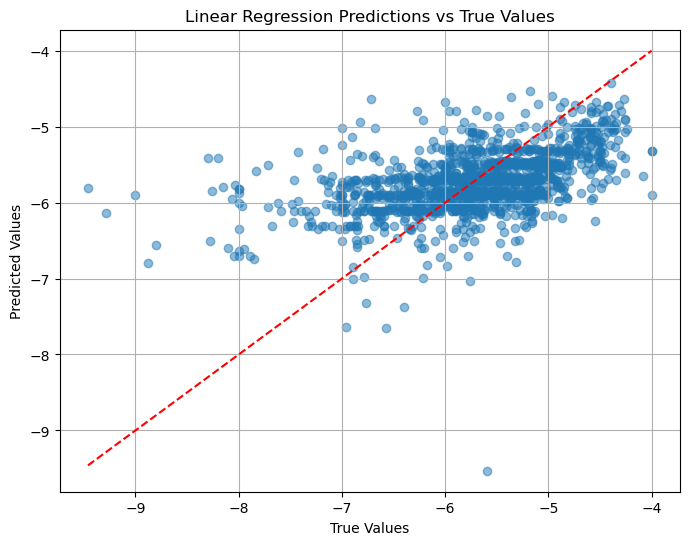

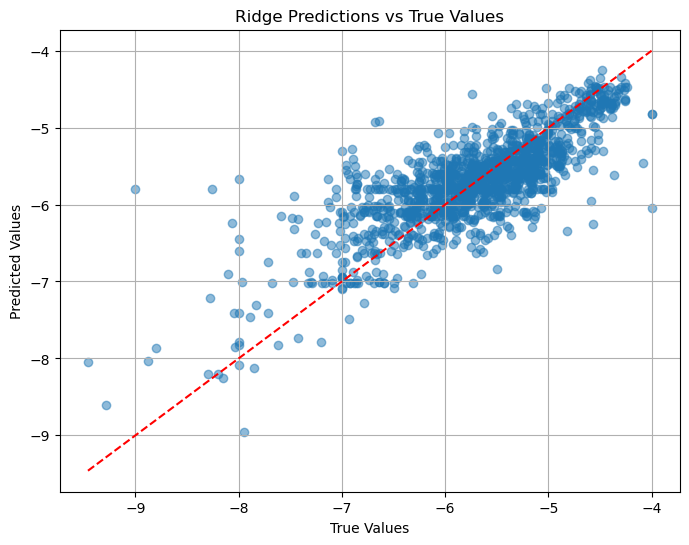

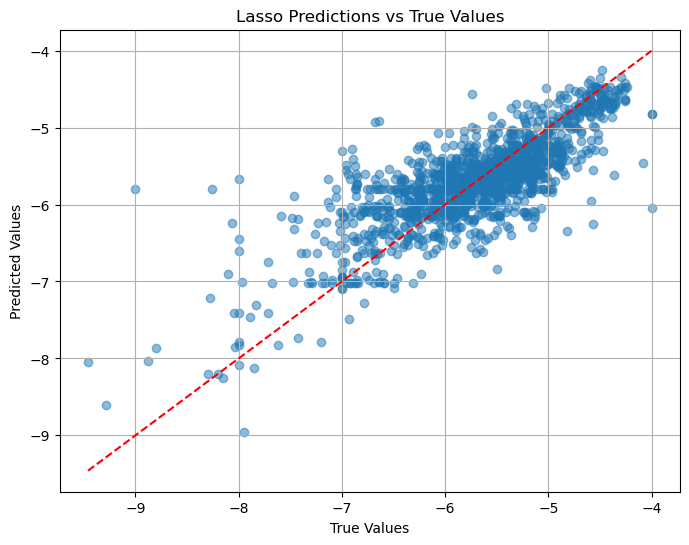

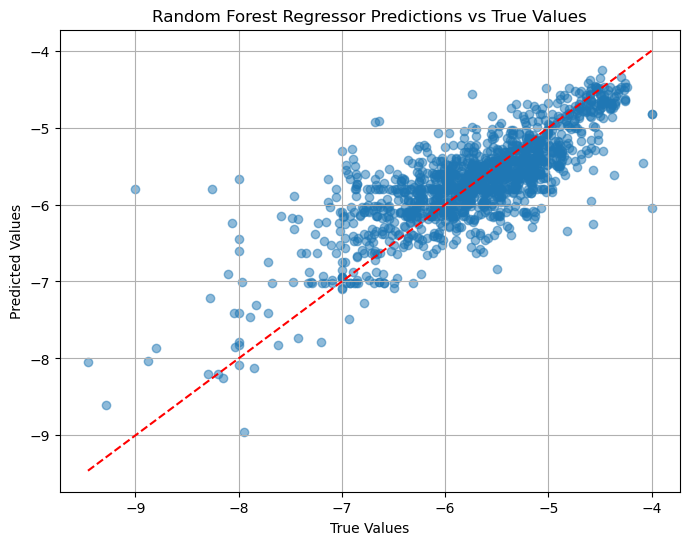

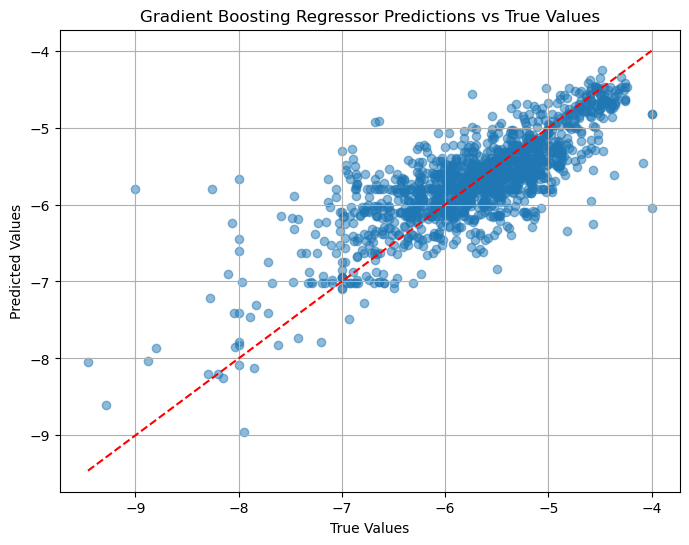

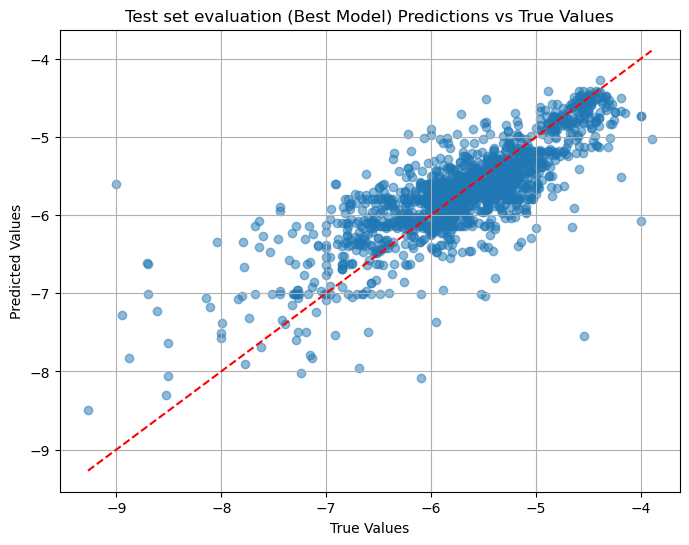

In [31]:
# Function to plot predictions vs true values
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--r')  # Diagonal line
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} Predictions vs True Values')
    plt.grid(True)
    plt.show()

# Plot for each model
for name, model in models.items():
    if name in param_grids:
        best_model = grid_search.best_estimator_  # Use the best model found by grid search
    else:
        best_model = model
    
    # Predict on validation set
    y_val_pred = best_model.predict(X_val)
    
    # Plot predictions vs true values
    plot_predictions(y_val, y_val_pred, name)

# Optionally, plot for the test set evaluation of the best model
y_test_pred = best_model.predict(X_test)
plot_predictions(y_test, y_test_pred, "Test set evaluation (Best Model)")

### Printing weights ###

In [15]:
# Initialize a dictionary to store feature weights
feature_weights = {}

# Feature names (excluding the bias term)
feature_names = columns + ['Bias Term']

# Extract feature weights or importances for each model
for name, model in models.items():
    if hasattr(model, 'coef_'):
        # For linear models
        weights = model.coef_
    elif hasattr(model, 'feature_importances_'):
        # For tree-based models
        weights = model.feature_importances_
    else:
        # Skip models that do not have interpretable feature importances
        continue
    
    # Create a dictionary of feature names and their corresponding weights
    feature_weights[name] = {feature: weight for feature, weight in zip(feature_names, weights)}
    
    # Sort the dictionary by absolute weight values in descending order
    feature_weights[name] = dict(sorted(feature_weights[name].items(), key=lambda item: abs(item[1]), reverse=True))

# Print the feature weights for each model
for name, weights in feature_weights.items():
    print(f"Feature weights for {name}:")
    for feature, weight in weights.items():
        print(f"  {feature}: {weight}")
    print()

Feature weights for Linear Regression:
  fr_Ar_NH: -3712503578022.287
  fr_Nhpyrrole: 3699392287875.923
  NumSaturatedRings: 2432919416067.335
  NumSaturatedHeterocycles: -2382732709422.2095
  NumRotatableBonds: 1678152541899.4414
  NumHDonors: 1329751714701.392
  fr_ketone_Topliss: -1233777624381.3367
  fr_ketone: 1233777624381.3286
  fr_Al_COO: -721061181993.5986
  NHOHCount: -720610901282.822
  NumSaturatedCarbocycles: -707616097538.7589
  NumHeteroatoms: 625648314895.0669
  fr_NH1: -537389407652.845
  NumHAcceptors: -487401552884.7
  fr_amide: -392261055543.9801
  fr_COO2: 371849068041.24524
  fr_COO: 330135644990.4816
  NOCount: 252934560052.52744
  fr_C_O: 166884465015.36768
  fr_C_O_noCOO: -166848781256.6166
  fr_Al_OH: -150909285117.4111
  fr_alkyl_carbamate: -140965518621.24072
  fr_C_S: 91462939035.6796
  fr_Ar_COO: 72949083090.74513
  fr_amidine: -57271429758.91031
  fr_N_O: -51269196951.00114
  fr_halogen: -46704981268.55118
  fr_azo: 46320593474.45642
  fr_phenol: -4405730